In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../data/C34-1522.csv')
codMunicipios = pd.read_csv('../data/MUNICSBR.csv')
codHospitais = pd.read_csv('../data/CNESBR.csv')
df['MUNIC_RES'] = df['MUNIC_RES'].map(codMunicipios.set_index('COD')['MUNIC'])
df['CNES'] = df['CNES'].map(codHospitais.set_index('CNES')['NOMEFANT'])

In [4]:
df.columns

Index(['UF_ZI', 'ANO_CMPT', 'MES_CMPT', 'ESPEC', 'CGC_HOSP', 'N_AIH', 'IDENT',
       'CEP', 'MUNIC_RES', 'NASC',
       ...
       'DIAGSEC9', 'TPDISEC1', 'TPDISEC2', 'TPDISEC3', 'TPDISEC4', 'TPDISEC5',
       'TPDISEC6', 'TPDISEC7', 'TPDISEC8', 'TPDISEC9'],
      dtype='object', length=113)

In [5]:
# Cria o grafo de hospitais e municipios, sendo a frequencia de atendimentos o peso das arestas
G = nx.Graph()
for i, row in df.iterrows():
    if row['MUNIC_RES'] not in G.nodes:
        G.add_node(row['MUNIC_RES'], tipo='municipio')
    if row['CNES'] not in G.nodes:
        G.add_node(row['CNES'], tipo='hospital')
    if G.has_edge(row['MUNIC_RES'], row['CNES']):
        G[row['MUNIC_RES']][row['CNES']]['weight'] += 1
    else:
        G.add_edge(row['MUNIC_RES'], row['CNES'], weight=1)

In [6]:
print('Quantidade de Nós:', G.number_of_nodes())
print('Quantidade de Arestas:', G.number_of_edges())
print('Quantidade de Internações:', sum([G[u][v]['weight'] for u, v in G.edges]))

Quantidade de Nós: 318
Quantidade de Arestas: 616
Quantidade de Internações: 6102


In [7]:
qntdInternacoesMunic = df['MUNIC_RES'].value_counts()
qntdInternacoesMunic

MUNIC_RES
FORTALEZA, CE            2723
CAUCAIA, CE               259
MARACANAU, CE             178
RUSSAS, CE                155
JUAZEIRO DO NORTE, CE     139
                         ... 
UBERABA, MG                 1
ANTONINA DO NORTE, CE       1
PENAFORTE, CE               1
PACUJA, CE                  1
PIQUET CARNEIRO, CE         1
Name: count, Length: 185, dtype: int64

In [8]:
qntdInternacoesHosp = df['CNES'].value_counts()
qntdInternacoesHosp

CNES
HM HOSPITAL DE MESSEJANA DR CARLOS ALBERTO STUDART GOMES       3508
HOSPITAL MATERNIDADE SAO VICENTE DE PAULO HMSVP                 317
HOSPITAL HAROLDO JUACABA                                        264
HGCC HOSPITAL GERAL DR CESAR CALS                               214
SANTA CASA DE MISERICORDIA DE SOBRAL                            166
                                                               ... 
HOSPITAL E CENTRO DE PARTO NORMAL DE PINDORETAMA                  1
HOSP PUBLICO MUNICIPAL S QUITERIA                                 1
HOSPITAL DE PEQUENO PORTE SAO FRANCISCO SALITRE                   1
HOSP MATERN LUZIA T DA COSTA                                      1
HOSPITAL MUNICIPAL DE ACOPIARA PADRE CRISARES SAMPAIO COUTO       1
Name: count, Length: 133, dtype: int64

In [32]:
df_messejana = df[df['CNES'] == 'HM HOSPITAL DE MESSEJANA DR CARLOS ALBERTO STUDART GOMES']

In [9]:
centralidade = nx.degree_centrality(G)
centralidade_df = pd.DataFrame(list(centralidade.items()), columns=['Nó', 'Centralidade'])
top_nos = centralidade_df.sort_values(by='Centralidade', ascending=False).head(10)
top_nos


,Nó,Centralidade
14,HM HOSPITAL DE MESSEJANA DR CARLOS ALBERTO STU...,0.435331
69,HOSPITAL HAROLDO JUACABA,0.141956
13,HGCC HOSPITAL GERAL DR CESAR CALS,0.138801
37,SANTA CASA DE MISERICORDIA DE SOBRAL,0.129338
28,HGF HOSPITAL GERAL DE FORTALEZA,0.113565
57,HOSPITAL MATERNIDADE SAO VICENTE DE PAULO HMSVP,0.100946
26,HOSPITAL UNIVERSITARIO WALTER CANTIDIO,0.085174
0,"FORTALEZA, CE",0.066246
6,HOSPITAL REGIONAL NORTE,0.063091
22,CRIO CENTRO REGIONAL INTEGRADO DE ONCOLOGIA,0.063091


In [34]:
dados_agrupados = df.groupby(['ANO_CMPT', 'MES_CMPT'])
dados_agrupados_messejana = df_messejana.groupby(['ANO_CMPT', 'MES_CMPT'])

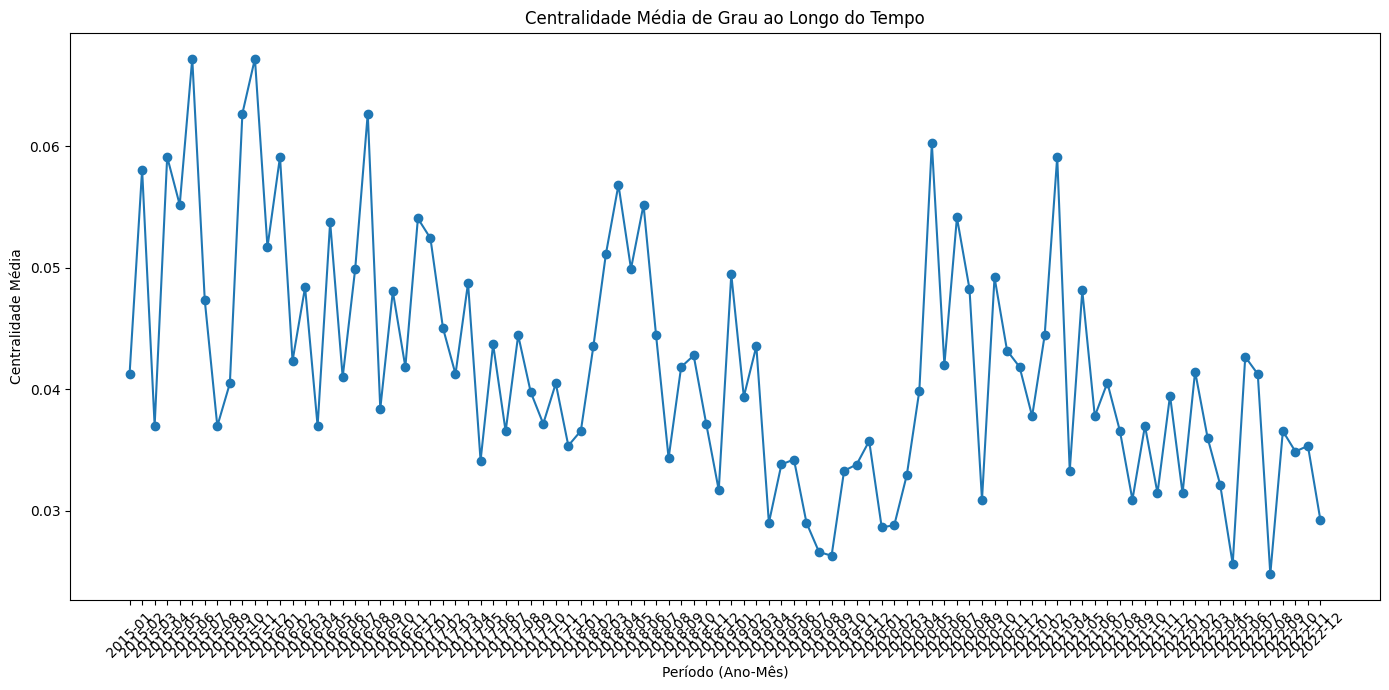

In [11]:
centralidade_media_por_periodo = []

for nome, grupo in dados_agrupados:
    Gdg = nx.Graph()  # Inicialize o grafo fora do loop interno
    for index, row in grupo.iterrows():
        Gdg.add_edge(row['MUNIC_RES'], row['CNES'])
    
    # Calcula a centralidade média para o período após adicionar todas as arestas do grupo
    centralidade = nx.degree_centrality(Gdg)
    centralidade_media = sum(centralidade.values()) / len(centralidade)
    
    # Adiciona o resultado na lista, incluindo o ano e mês para referência
    centralidade_media_por_periodo.append((*nome, centralidade_media))

# Convertendo os resultados em um DataFrame
df_centralidade_media = pd.DataFrame(centralidade_media_por_periodo, columns=['Ano', 'Mês', 'Centralidade Média'])

plt.figure(figsize=(14, 7))
plt.plot(range(len(df_centralidade_media)), df_centralidade_media['Centralidade Média'], marker='o', linestyle='-')
plt.title('Centralidade Média de Grau ao Longo do Tempo')
plt.xlabel('Período (Ano-Mês)')
plt.ylabel('Centralidade Média')
plt.xticks(range(len(df_centralidade_media)), [f"{ano}-{mes:02d}" for ano, mes in zip(df_centralidade_media['Ano'], df_centralidade_media['Mês'])], rotation=45)
plt.tight_layout()
plt.show()


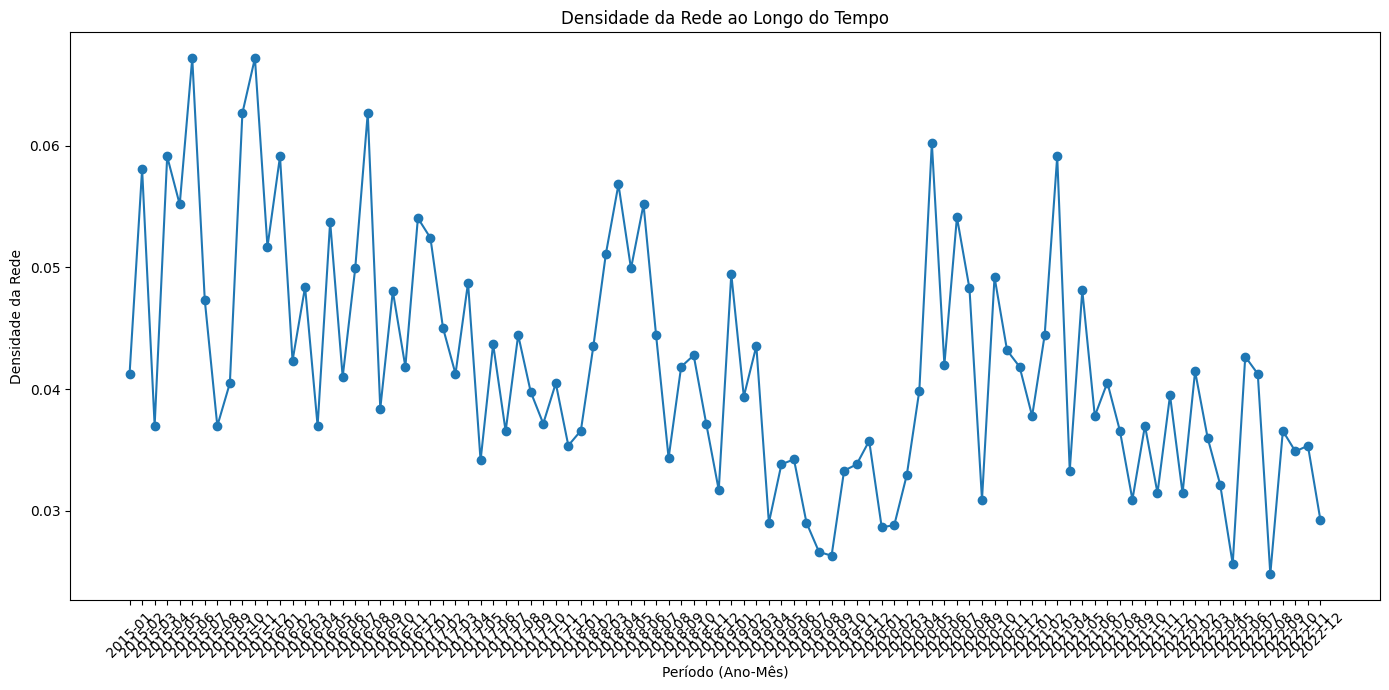

In [12]:
densidade_por_periodo = []

for (ano, mes), grupo in dados_agrupados:
    Gden = nx.Graph()  # Inicialize o grafo Gden para cada período aqui
    for index, row in grupo.iterrows():
        Gden.add_edge(row['MUNIC_RES'], row['CNES'])
    
    # Calcula a densidade da rede para o período usando o grafo Gden
    densidade = nx.density(Gden)
    
    # Adiciona o resultado na lista
    densidade_por_periodo.append((ano, mes, densidade))

# Convertendo os resultados em um DataFrame
df_densidade = pd.DataFrame(densidade_por_periodo, columns=['Ano', 'Mês', 'Densidade da Rede'])

plt.figure(figsize=(14, 7))
plt.plot(range(len(df_densidade)), df_densidade['Densidade da Rede'], marker='o', linestyle='-')
plt.title('Densidade da Rede ao Longo do Tempo')
plt.xlabel('Período (Ano-Mês)')
plt.ylabel('Densidade da Rede')
plt.xticks(range(len(df_densidade)), [f"{ano}-{mes:02d}" for ano, mes in zip(df_densidade['Ano'], df_densidade['Mês'])], rotation=45)
plt.tight_layout()
plt.show()

In [13]:
densidade_total = nx.density(G)
centralidade_total = nx.degree_centrality(G)
print(f'Densidade total: {densidade_total}')
print(f'Centralidade total: {sum(centralidade_total.values()) / len(centralidade_total)}')

Densidade total: 0.01222149475229649
Centralidade total: 0.012221494752296455


In [14]:
df_centralidade_media

,Ano,Mês,Centralidade Média
0,2015,1,0.041252
1,2015,2,0.058065
2,2015,3,0.036998
3,2015,4,0.059113
4,2015,5,0.055172
...,...,...,...
91,2022,8,0.024803
92,2022,9,0.036565
93,2022,10,0.034884
94,2022,11,0.035354


In [15]:
df_densidade

,Ano,Mês,Densidade da Rede
0,2015,1,0.041252
1,2015,2,0.058065
2,2015,3,0.036998
3,2015,4,0.059113
4,2015,5,0.055172
...,...,...,...
91,2022,8,0.024803
92,2022,9,0.036565
93,2022,10,0.034884
94,2022,11,0.035354


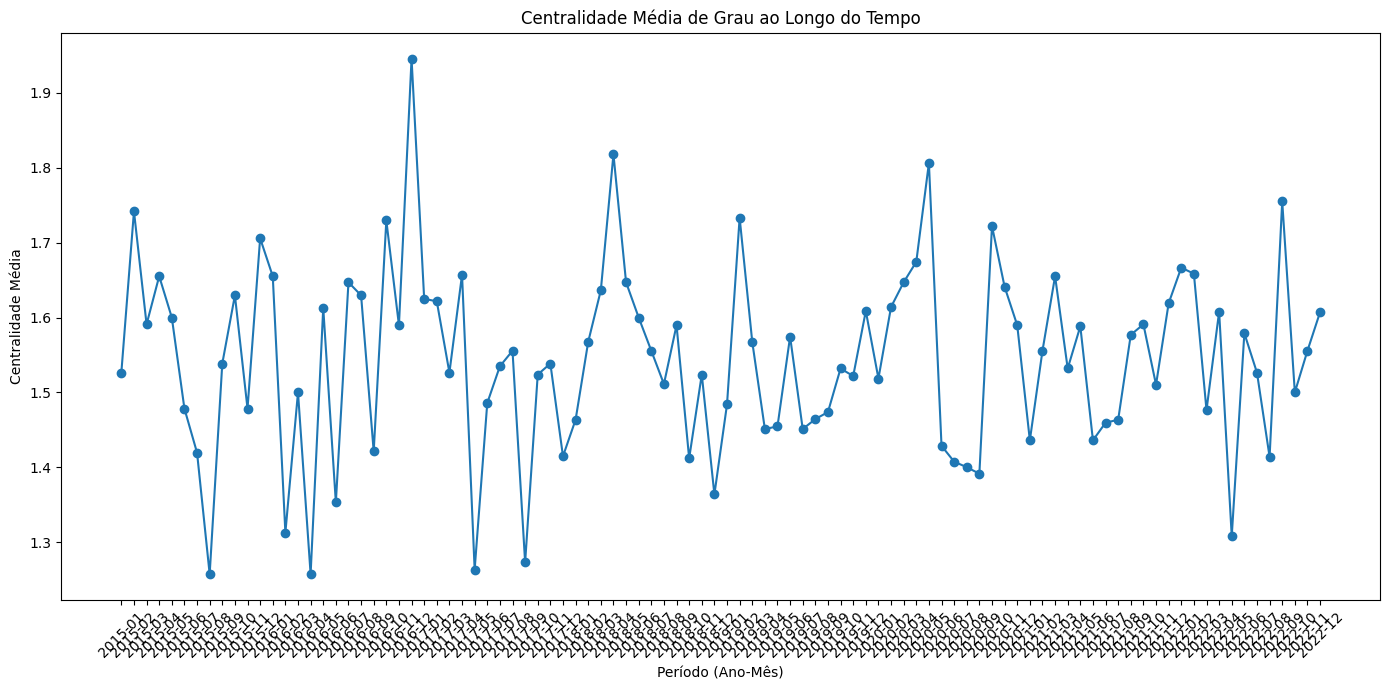

In [16]:
centralidade_media_por_periodo2 = []

for nome, grupo in dados_agrupados:
    Gdg = nx.Graph()  # Inicialize o grafo fora do loop interno
    for index, row in grupo.iterrows():
        Gdg.add_edge(row['MUNIC_RES'], row['CNES'])
    
    # Calcula a centralidade média para o período após adicionar todas as arestas do grupo
    # centralidade = nx.degree_centrality(Gdg)
    # centralidade_media = sum(centralidade.values()) / len(centralidade)
    
    # Adiciona o resultado na lista, incluindo o ano e mês para referência
    centralidade_media_por_periodo2.append((*nome,np.mean([d for n, d in Gdg.degree()])))

# Convertendo os resultados em um DataFrame
df_centralidade_media2 = pd.DataFrame(centralidade_media_por_periodo2, columns=['Ano', 'Mês', 'Centralidade Média'])

plt.figure(figsize=(14, 7))
plt.plot(range(len(df_centralidade_media2)), df_centralidade_media2['Centralidade Média'], marker='o', linestyle='-')
plt.title('Centralidade Média de Grau ao Longo do Tempo')
plt.xlabel('Período (Ano-Mês)')
plt.ylabel('Centralidade Média')
plt.xticks(range(len(df_centralidade_media2)), [f"{ano}-{mes:02d}" for ano, mes in zip(df_centralidade_media2['Ano'], df_centralidade_media2['Mês'])], rotation=45)
plt.tight_layout()
plt.show()


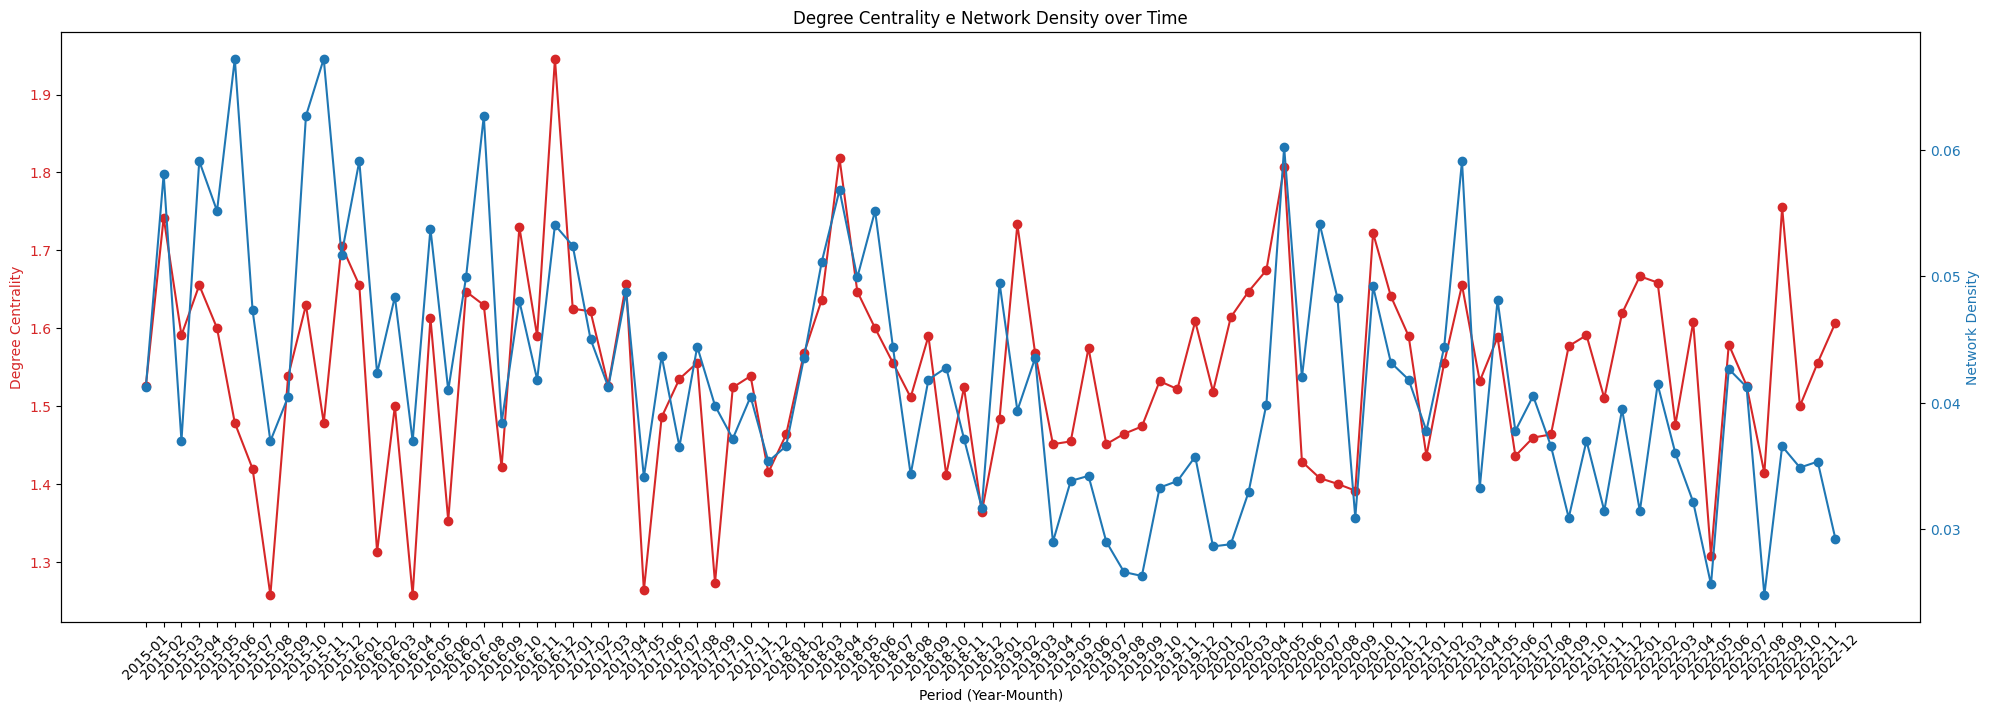

In [59]:
fig, ax1 = plt.subplots(figsize=(20, 7))

color = 'tab:red'
ax1.set_xlabel('Period (Year-Mounth)')
ax1.set_ylabel('Degree Centrality', color=color)
ax1.plot(range(len(df_centralidade_media2)), df_centralidade_media2['Centralidade Média'], marker='o', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(len(df_centralidade_media2)))
ax1.set_xticklabels([f"{ano}-{mes:02d}" for ano, mes in zip(df_centralidade_media2['Ano'], df_centralidade_media2['Mês'])], rotation=45)

ax2 = ax1.twinx()  # Inicia o segundo eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Network Density', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(df_densidade)), df_densidade['Densidade da Rede'], marker='o', linestyle='-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # Para garantir que o layout não sobreponha elementos
plt.title('Degree Centrality e Network Density over Time')
plt.show()


In [35]:
centralidade_media_por_periodo_messejana = []
densidade_por_periodo_messejana = []

for nome, grupo in dados_agrupados_messejana:
    Gdg = nx.Graph()  # Inicialize o grafo fora do loop interno
    for index, row in grupo.iterrows():
        Gdg.add_edge(row['MUNIC_RES'], row['CNES'])
    
    # Adiciona o resultado na lista, incluindo o ano e mês para referência
    centralidade_media_por_periodo_messejana.append((*nome,np.mean([d for n, d in Gdg.degree()])))
    
    densidade_messejana = nx.density(Gdg)
    
    # Adiciona o resultado na lista
    densidade_por_periodo_messejana.append((ano, mes, densidade))

# Convertendo os resultados em um DataFrame
df_centralidade_media_messejana = pd.DataFrame(centralidade_media_por_periodo_messejana, columns=['Ano', 'Mês', 'Centralidade Média'])

# Convertendo os resultados em um DataFrame
df_densidade_messejana = pd.DataFrame(densidade_por_periodo, columns=['Ano', 'Mês', 'Densidade da Rede'])

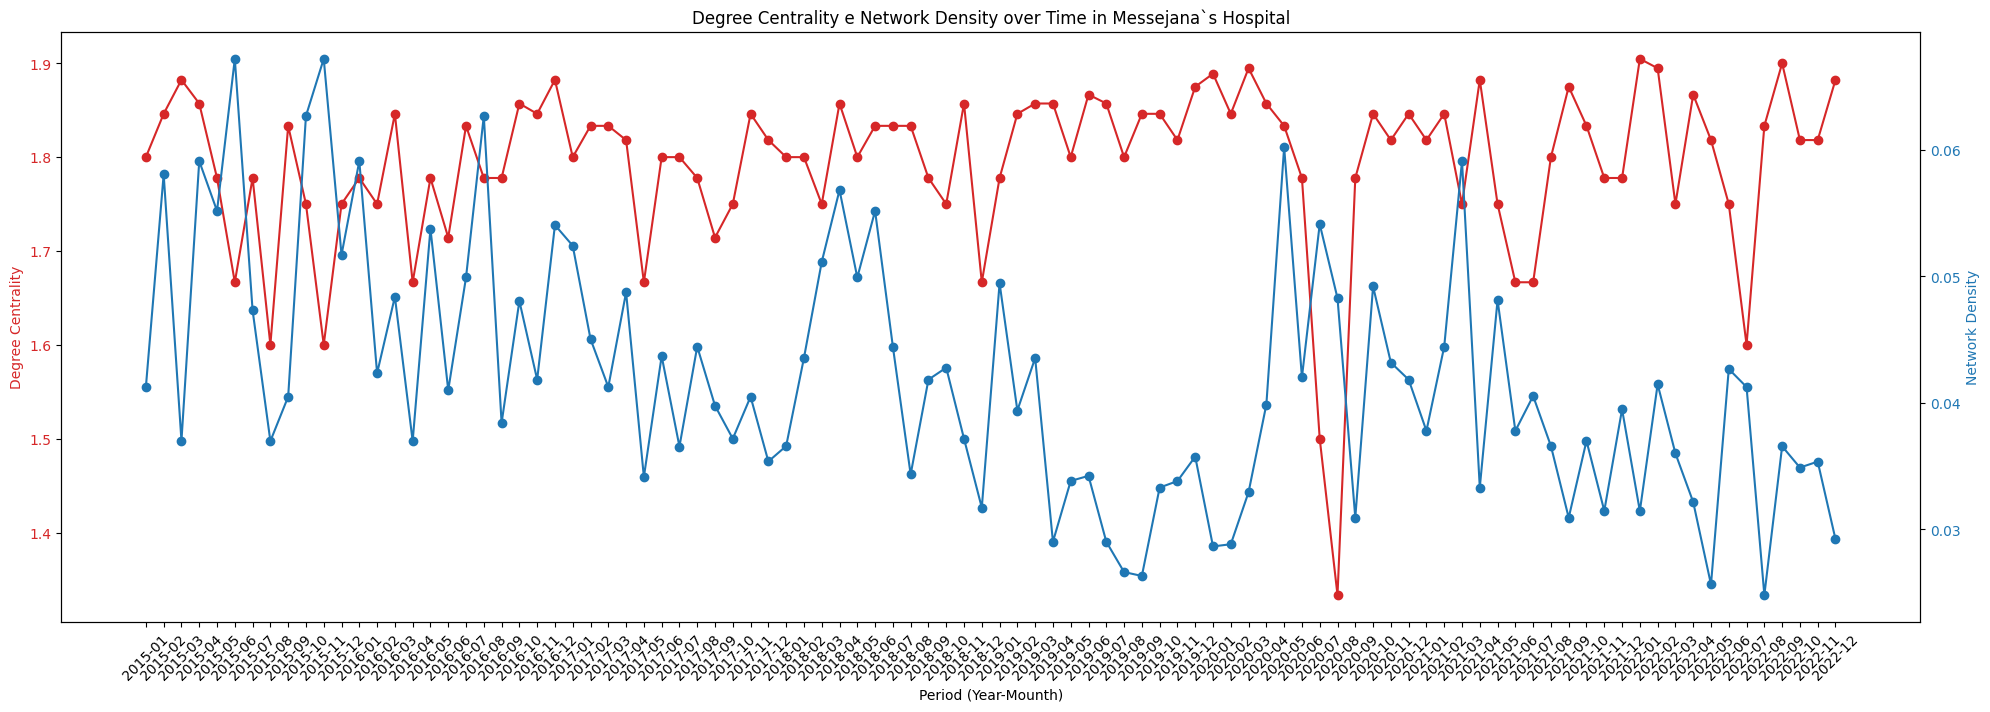

In [58]:
fig, ax1 = plt.subplots(figsize=(20, 7))

color = 'tab:red'
ax1.set_xlabel('Period (Year-Mounth)')
ax1.set_ylabel('Degree Centrality', color=color)
ax1.plot(range(len(df_centralidade_media_messejana)), df_centralidade_media_messejana['Centralidade Média'], marker='o', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(len(df_centralidade_media_messejana)))
ax1.set_xticklabels([f"{ano}-{mes:02d}" for ano, mes in zip(df_centralidade_media_messejana['Ano'], df_centralidade_media_messejana['Mês'])], rotation=45)

ax2 = ax1.twinx()  # Inicia o segundo eixo que compartilha o mesmo eixo x
color = 'tab:blue'
ax2.set_ylabel('Network Density', color=color)  # we already handled the x-label with ax1
ax2.plot(range(len(df_densidade_messejana)), df_densidade_messejana['Densidade da Rede'], marker='o', linestyle='-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # Para garantir que o layout não sobreponha elementos
plt.title('Degree Centrality e Network Density over Time in Messejana`s Hospital')
plt.show()


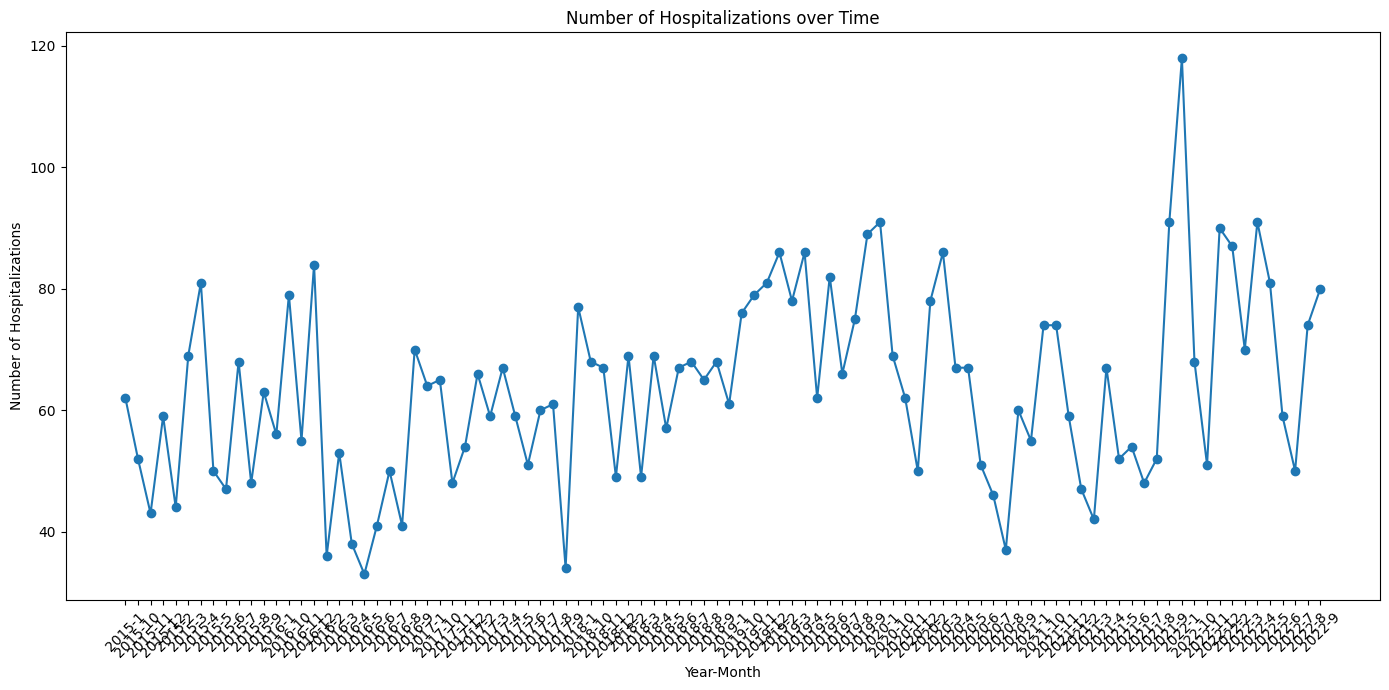

In [41]:
# Quantidade de internações por mês Total
df['ANO_CMPT'] = df['ANO_CMPT'].astype(str)
df['MES_CMPT'] = df['MES_CMPT'].astype(str)
df['ANO_MES'] = df['ANO_CMPT'] + '-' + df['MES_CMPT']
internacoes_por_mes = df['ANO_MES'].value_counts().sort_index()

# Grafico
plt.figure(figsize=(14, 7))
plt.plot(internacoes_por_mes.index, internacoes_por_mes.values, marker='o', linestyle='-')
plt.title('Number of Hospitalizations over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Hospitalizations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/qp/81kj72l557j92fgbrq5fmjy40000gn/T/ipykernel_67102/3869800688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_messejana['ANO_CMPT'] = df_messejana['ANO_CMPT'].astype(str)
/var/folders/qp/81kj72l557j92fgbrq5fmjy40000gn/T/ipykernel_67102/3869800688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_messejana['MES_CMPT'] = df_messejana['MES_CMPT'].astype(str)
/var/folders/qp/81kj72l557j92fgbrq5fmjy40000gn/T/ipykernel_67102/3869800688.py:4: SettingWithCopyWarning: 
A value is trying to 

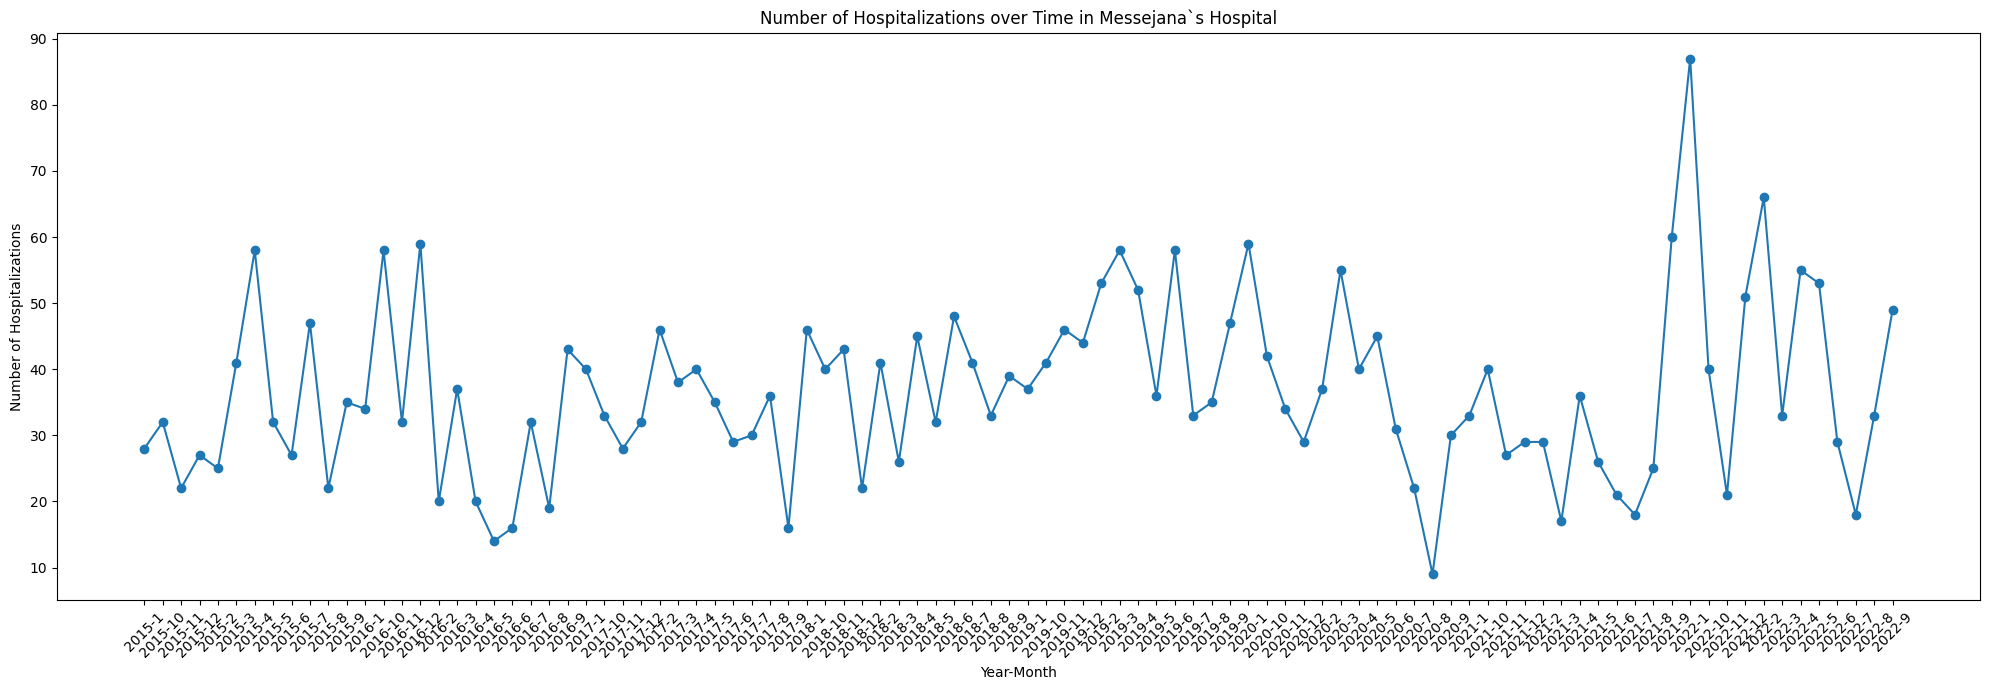

In [57]:
# Quantidade de internações por mês no Hospital de Messejana
df_messejana['ANO_CMPT'] = df_messejana['ANO_CMPT'].astype(str)
df_messejana['MES_CMPT'] = df_messejana['MES_CMPT'].astype(str)
df_messejana['ANO_MES'] = df_messejana['ANO_CMPT'] + '-' + df_messejana['MES_CMPT']
internacoes_por_mes_messejana = df_messejana['ANO_MES'].value_counts().sort_index()

# Grafico
plt.figure(figsize=(20, 7))
plt.plot(internacoes_por_mes_messejana.index, internacoes_por_mes_messejana.values, marker='o', linestyle='-')
plt.title('Number of Hospitalizations over Time in Messejana`s Hospital')
plt.xlabel('Year-Month')
plt.ylabel('Number of Hospitalizations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [45]:
# Quantidade de internações por mês sem o Hospital de Messejana
internacoes_por_mes_sem_messejana = internacoes_por_mes - internacoes_por_mes_messejana

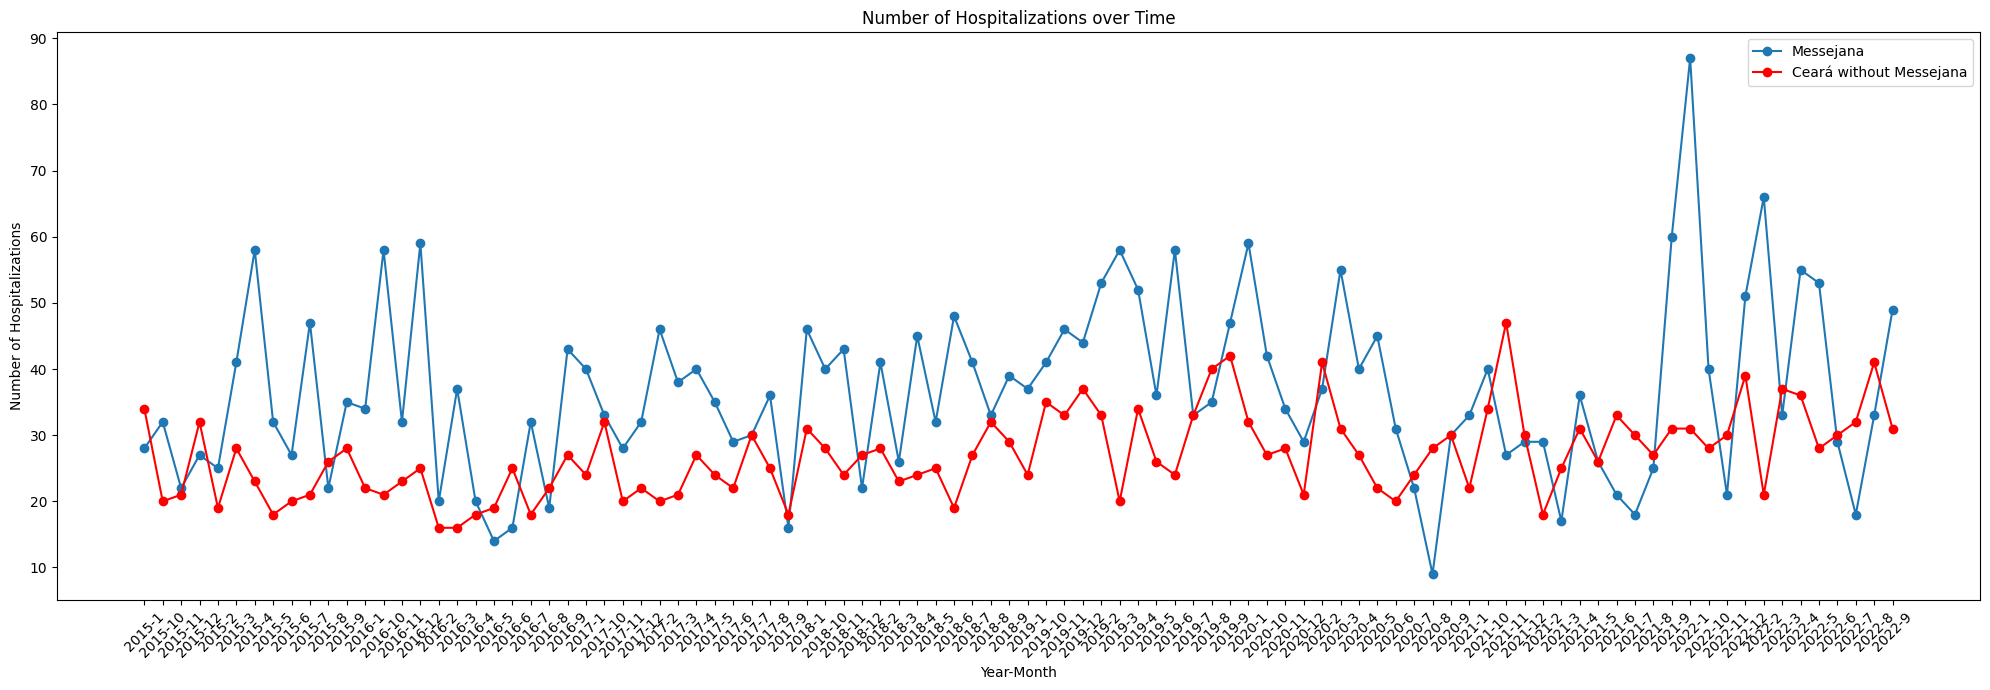

In [56]:
# Grafico comparativo
plt.figure(figsize=(20, 7))
plt.plot(internacoes_por_mes_messejana.index, internacoes_por_mes_messejana.values, marker='o', linestyle='-', label='Messejana')
plt.plot(internacoes_por_mes_sem_messejana.index, internacoes_por_mes_sem_messejana.values, color="red" , marker='o', linestyle='-', label='Ceará without Messejana')
plt.title('Number of Hospitalizations over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Hospitalizations')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
